100%|██████████| 26.4M/26.4M [00:02<00:00, 10.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 173kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.10MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.1MB/s]


Epoch 1/10 | Train Loss: 0.5462, Acc: 80.02% | Val Loss: 0.4055, Acc: 85.00%
Epoch 2/10 | Train Loss: 0.3614, Acc: 86.74% | Val Loss: 0.3186, Acc: 88.24%
Epoch 3/10 | Train Loss: 0.3089, Acc: 88.64% | Val Loss: 0.2835, Acc: 89.33%
Epoch 4/10 | Train Loss: 0.2782, Acc: 89.75% | Val Loss: 0.2675, Acc: 90.37%
Epoch 5/10 | Train Loss: 0.2527, Acc: 90.65% | Val Loss: 0.2601, Acc: 90.47%
Epoch 6/10 | Train Loss: 0.2281, Acc: 91.54% | Val Loss: 0.2507, Acc: 90.87%
Epoch 7/10 | Train Loss: 0.2093, Acc: 92.29% | Val Loss: 0.2565, Acc: 90.67%
Epoch 8/10 | Train Loss: 0.1983, Acc: 92.69% | Val Loss: 0.2589, Acc: 90.75%
Epoch 9/10 | Train Loss: 0.1834, Acc: 93.11% | Val Loss: 0.2440, Acc: 91.32%
Epoch 10/10 | Train Loss: 0.1711, Acc: 93.52% | Val Loss: 0.2445, Acc: 91.70%


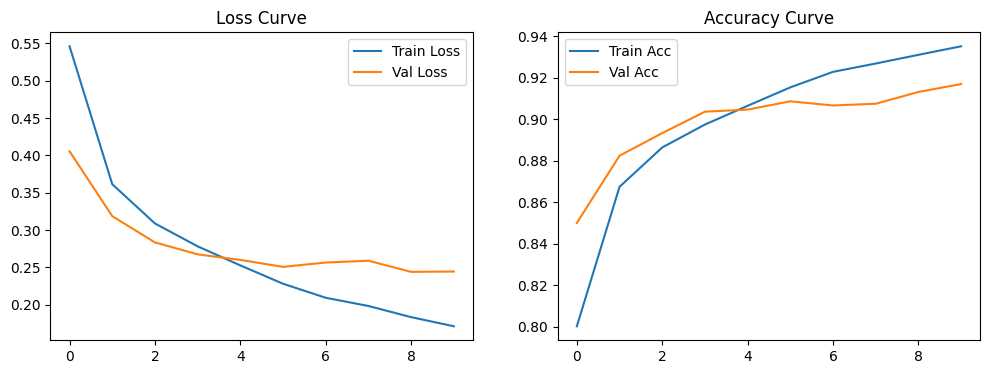

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_val = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_val))
val_size = len(train_val) - train_size
train, val = random_split(train_val, [train_size, val_size])

train_loader = DataLoader(train, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test, batch_size=64, shuffle=False, num_workers=0)

class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 5 * 5, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FashionCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(10):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)

    print(f"Epoch {epoch+1}/10 | Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]*100:.2f}% | Val Loss: {val_losses[-1]:.4f}, Acc: {val_accs[-1]*100:.2f}%")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(), plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend(), plt.title("Accuracy Curve")
plt.show()


<Figure size 800x600 with 0 Axes>

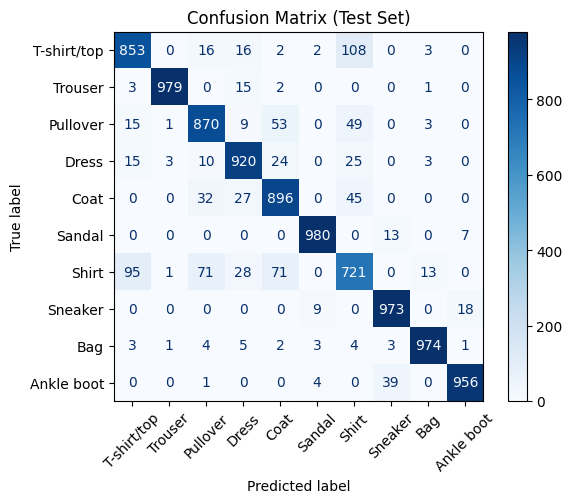

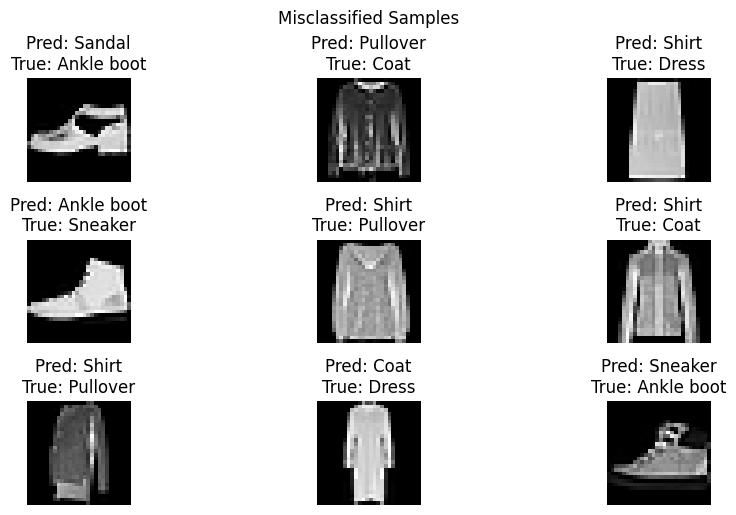

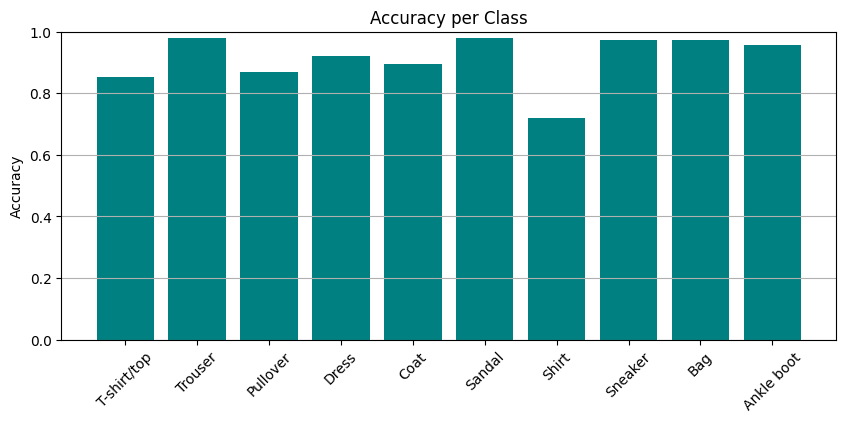

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test.classes)
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (Test Set)")
plt.grid(False)
plt.show()

def show_misclassified(n=9):
    misclassified = []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            for i in range(len(preds)):
                if preds[i] != labels[i]:
                    misclassified.append((imgs[i].cpu(), preds[i].item(), labels[i].item()))
                if len(misclassified) >= n:
                    break
            if len(misclassified) >= n:
                break

    plt.figure(figsize=(10, 5))
    for i, (img, pred, true) in enumerate(misclassified):
        plt.subplot(3, 3, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"Pred: {test.classes[pred]}\nTrue: {test.classes[true]}")
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle("Misclassified Samples", y=1.02)
    plt.show()

show_misclassified()

correct_per_class = [0] * 10
total_per_class = [0] * 10

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        for i in range(len(labels)):
            label = labels[i].item()
            total_per_class[label] += 1
            if preds[i] == label:
                correct_per_class[label] += 1

accuracy_per_class = [c / t if t > 0 else 0 for c, t in zip(correct_per_class, total_per_class)]

plt.figure(figsize=(10, 4))
plt.bar(test.classes, accuracy_per_class, color='teal')
plt.title("Accuracy per Class")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()